In [387]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [388]:
df = pd.read_csv('./data/car_price_prediction.csv')
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [389]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [390]:
df = df.rename(columns={
    "Prod. year": "ProdYear",
    "Leather interior": "LeatherInterior",
    "Fuel type": "FuelType",
    "Engine volume": "EngineVolume",
    "Gear box type": "GearBoxType",
    "Drive wheels": "DriveWheels"
})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               19237 non-null  int64  
 1   Price            19237 non-null  int64  
 2   Levy             19237 non-null  object 
 3   Manufacturer     19237 non-null  object 
 4   Model            19237 non-null  object 
 5   ProdYear         19237 non-null  int64  
 6   Category         19237 non-null  object 
 7   LeatherInterior  19237 non-null  object 
 8   FuelType         19237 non-null  object 
 9   EngineVolume     19237 non-null  object 
 10  Mileage          19237 non-null  object 
 11  Cylinders        19237 non-null  float64
 12  GearBoxType      19237 non-null  object 
 13  DriveWheels      19237 non-null  object 
 14  Doors            19237 non-null  object 
 15  Wheel            19237 non-null  object 
 16  Color            19237 non-null  object 
 17  Airbags     

In [391]:
df.isnull().sum()

ID                 0
Price              0
Levy               0
Manufacturer       0
Model              0
ProdYear           0
Category           0
LeatherInterior    0
FuelType           0
EngineVolume       0
Mileage            0
Cylinders          0
GearBoxType        0
DriveWheels        0
Doors              0
Wheel              0
Color              0
Airbags            0
dtype: int64

In [392]:
df.duplicated().sum()

np.int64(313)

In [393]:
df = df.drop_duplicates()
df.duplicated().sum()

np.int64(0)

In [394]:
df['Levy'] = pd.to_numeric(df['Levy'].replace('-', np.nan), errors='coerce')

In [395]:
total_rows = len(df)
missing_levy = df['Levy'].isnull().sum()
missing_percentage = (missing_levy / total_rows) * 100

print(f"Total rows: {total_rows}")
print(f"Missing Levy values: {missing_levy}")
print(f"Missing percentage: {missing_percentage:.2f}%")


Total rows: 18924
Missing Levy values: 5709
Missing percentage: 30.17%


In [396]:
levy_median = df['Levy'].median()
df['Levy'] = df['Levy'].fillna(levy_median)
df['Levy'].isnull().sum()

np.int64(0)

In [397]:
df['Mileage'] = df['Mileage'].astype(str).str.replace(' km', '', regex=False)
df['Mileage'] = df['Mileage'].str.replace(',', '', regex=False)
df['Mileage'] = pd.to_numeric(df['Mileage'], errors='coerce')

In [398]:
# Clean Doors
df['Doors'] = df['Doors'].replace({'04-May': '4', '02-Mar': '2', '>5': '6'})
df['Doors'] = pd.to_numeric(df['Doors'], errors='coerce')

# Clean EngineVolume (remove 'Turbo' or unit suffixes)
if df['EngineVolume'].dtype == 'object':
    df['EngineVolume'] = df['EngineVolume'].astype(str).str.replace('Turbo', '', regex=False).str.strip()
    df['EngineVolume'] = df['EngineVolume'].str.replace('L', '', regex=False).str.strip()
    df['EngineVolume'] = pd.to_numeric(df['EngineVolume'], errors='coerce')

# Clean Cylinders
if 'Cylinders' in df.columns and df['Cylinders'].dtype == 'object':
    df['Cylinders'] = pd.to_numeric(df['Cylinders'], errors='coerce')

# Clean Airbags
if 'Airbags' in df.columns and df['Airbags'].dtype == 'object':
    df['Airbags'] = pd.to_numeric(df['Airbags'], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18924 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               18924 non-null  int64  
 1   Price            18924 non-null  int64  
 2   Levy             18924 non-null  float64
 3   Manufacturer     18924 non-null  object 
 4   Model            18924 non-null  object 
 5   ProdYear         18924 non-null  int64  
 6   Category         18924 non-null  object 
 7   LeatherInterior  18924 non-null  object 
 8   FuelType         18924 non-null  object 
 9   EngineVolume     18924 non-null  float64
 10  Mileage          18924 non-null  int64  
 11  Cylinders        18924 non-null  float64
 12  GearBoxType      18924 non-null  object 
 13  DriveWheels      18924 non-null  object 
 14  Doors            18924 non-null  int64  
 15  Wheel            18924 non-null  object 
 16  Color            18924 non-null  object 
 17  Airbags          

In [399]:
df["Model"].nunique()

1590

In [400]:
top_models = df['Model'].value_counts().nlargest(30).index

df['Model_reduced'] = df['Model'].where(
    df['Model'].isin(top_models),
    'Other'
)

In [401]:
categorical_cols = [
    'Manufacturer', 'Model_reduced', 'Category', 'LeatherInterior',
    'FuelType', 'GearBoxType', 'DriveWheels', 'Wheel', 'Color'
]

df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [402]:
class TopNCategoryReducer(BaseEstimator, TransformerMixin):
    def __init__(self, column, top_n=30):
        self.column = column
        self.top_n = top_n

    def fit(self, X, y=None):
        # Learn top N categories from training data
        self.top_categories_ = (
            pd.Series(X[self.column])
            .value_counts()
            .nlargest(self.top_n)
            .index
        )
        return self

    def transform(self, X):
        X = X.copy()
        X[self.column] = X[self.column].where(
            X[self.column].isin(self.top_categories_),
            'Other'
        )
        return X


In [403]:
num_cols = [
    'Levy', 'ProdYear', 'EngineVolume', 'Mileage',
    'Cylinders', 'Doors', 'Airbags'
]

cat_cols = [
    'Manufacturer', 'Model', 'Category', 'LeatherInterior',
    'FuelType', 'GearBoxType', 'DriveWheels', 'Wheel', 'Color'
]

In [404]:
lr_model_pipeline = Pipeline(steps=[
    ('top_n_model', TopNCategoryReducer(column='Model', top_n=30)),
    ('encode', ColumnTransformer(
        transformers=[
            ('num', 'passthrough', num_cols),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
        ]
    )),
    ('regressor', LinearRegression())
])

In [405]:
X = df.drop('Price', axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr_model_pipeline.fit(X_train, y_train)
y_pred = lr_model_pipeline.predict(X_test)
r2_score(y_test, y_pred)

c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-0.008072526466020191

In [406]:
pr_model_pipeline = Pipeline(steps=[
    ('top_n_model', TopNCategoryReducer(column='Model', top_n=30)),
    ('encode', ColumnTransformer(
        transformers=[
            ('num', 'passthrough', num_cols),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
        ]
    )),
    ('poly_features', PolynomialFeatures(degree=2)),
    ('regressor', LinearRegression())
])

In [407]:
pr_model_pipeline.fit(X_train, y_train)
y_pred_poly = pr_model_pipeline.predict(X_test)
r2_score(y_test, y_pred_poly)

c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-0.00803881672999629

In [408]:
for d in [2, 3]:
    pr_model_pipeline.set_params(poly_features__degree=d)
    pr_model_pipeline.fit(X_train, y_train)
    y_pred_poly = pr_model_pipeline.predict(X_test)
    score = r2_score(y_test, y_pred_poly)
    print(f"R² score with polynomial degree {d}: {score:.4f}")

c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R² score with polynomial degree 2: -0.0080


c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


R² score with polynomial degree 3: -0.0080


In [409]:
ridge_pipeline = Pipeline(steps=[
    ('top_n_model', TopNCategoryReducer(column='Model', top_n=30)),
    ('encode', ColumnTransformer(
        transformers=[
            ('num', 'passthrough', num_cols),
            ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
        ]
    )),
    ('regressor', Ridge(alpha=1.0))
])
ridge_pipeline.fit(X_train, y_train)
y_pred_ridge = ridge_pipeline.predict(X_test)
r2_score(y_test, y_pred_ridge)

c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


-0.008072526466020191

## Diagnosing the Poor R² Score

Let's investigate why the model is performing poorly.

In [410]:
# Check data quality and basic statistics
print("=== DATA QUALITY CHECK ===")
print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"\nMissing values in X_train:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
print(f"\nTarget variable (Price) stats:")
print(y_train.describe())
print(f"\nCheck for infinite values: {np.isinf(y_train).sum()}")
print(f"Negative prices: {(y_train < 0).sum()}")

=== DATA QUALITY CHECK ===

X_train shape: (15139, 18)
X_test shape: (3785, 18)

Missing values in X_train:
Series([], dtype: int64)

Target variable (Price) stats:
count    1.513900e+04
mean     1.892078e+04
std      2.146141e+05
min      1.000000e+00
25%      5.331000e+03
50%      1.317200e+04
75%      2.200000e+04
max      2.630750e+07
Name: Price, dtype: float64

Check for infinite values: 0
Negative prices: 0


In [411]:
# Check actual predictions vs target
print("=== PREDICTION ANALYSIS ===")
print(f"\nPredicted values stats:")
print(pd.Series(y_pred_ridge).describe())
print(f"\nActual values stats:")
print(y_test.describe())
print(f"\nAre predictions constant? {len(np.unique(y_pred_ridge)) == 1}")
print(f"Unique predictions: {len(np.unique(y_pred_ridge))}")

=== PREDICTION ANALYSIS ===

Predicted values stats:
count     3785.000000
mean     18918.601513
std        466.378366
min       1418.489333
25%      18931.499825
50%      18932.005487
75%      18932.452477
max      18933.033124
dtype: float64

Actual values stats:
count      3785.000000
mean      17254.127081
std       18609.666995
min           3.000000
25%        5175.000000
50%       13172.000000
75%       22473.000000
max      308906.000000
Name: Price, dtype: float64

Are predictions constant? False
Unique predictions: 3270


## Improved Pipeline with Better Preprocessing

In [412]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Create improved preprocessor with imputation and scaling
improved_preprocessor = Pipeline([
    ('top_n_model', TopNCategoryReducer(column='Model', top_n=30)),
    ('encode', ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), num_cols),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
            ]), cat_cols)
        ]
    ))
])

# Ridge with improved preprocessing
improved_ridge = Pipeline([
    ('preprocessor', improved_preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

improved_ridge.fit(X_train, y_train)
y_pred_improved = improved_ridge.predict(X_test)

print("=== IMPROVED RIDGE REGRESSION ===")
print(f"Test R²: {r2_score(y_test, y_pred_improved):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_improved)):,.2f}")
print(f"MAE: ${mean_absolute_error(y_test, y_pred_improved):,.2f}")

=== IMPROVED RIDGE REGRESSION ===
Test R²: -0.9153
RMSE: $25,751.32
MAE: $14,815.09


c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [413]:
# Try different Ridge alpha values with cross-validation
from sklearn.linear_model import RidgeCV

ridge_cv = Pipeline([
    ('preprocessor', improved_preprocessor),
    ('regressor', RidgeCV(alphas=[0.01, 0.1, 1.0, 10.0, 100.0], cv=5))
])

ridge_cv.fit(X_train, y_train)
y_pred_cv = ridge_cv.predict(X_test)

print("=== RIDGE WITH CROSS-VALIDATION ===")
print(f"Best alpha: {ridge_cv.named_steps['regressor'].alpha_}")
print(f"Test R²: {r2_score(y_test, y_pred_cv):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_cv)):,.2f}")

=== RIDGE WITH CROSS-VALIDATION ===
Best alpha: 100.0
Test R²: -0.4207
RMSE: $22,178.87


c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Compare Multiple Models

In [414]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso

# Dictionary of models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Ridge (alpha=1.0)': Ridge(alpha=1.0),
    'Ridge (alpha=10.0)': Ridge(alpha=10.0),
    'Lasso': Lasso(alpha=1.0, max_iter=10000),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', improved_preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    results[name] = {
        'R²': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

# Display results
results_df = pd.DataFrame(results).T.sort_values('R²', ascending=False)
print("=== MODEL COMPARISON ===")
print(results_df)

c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encode

=== MODEL COMPARISON ===
                            R²           RMSE           MAE
Ridge (alpha=10.0)   -0.811181   25041.604678  14591.741932
Ridge (alpha=1.0)    -0.915298   25751.315563  14815.094545
Lasso                -0.929516   25846.718040  14826.270063
Linear Regression    -0.938440   25906.419640  14847.459284
Random Forest       -30.695250  104755.857352   7330.735092
Gradient Boosting  -133.689918  215947.792077  15519.754638


c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Visualize Best Model Performance

Best model: Ridge (alpha=10.0)


c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


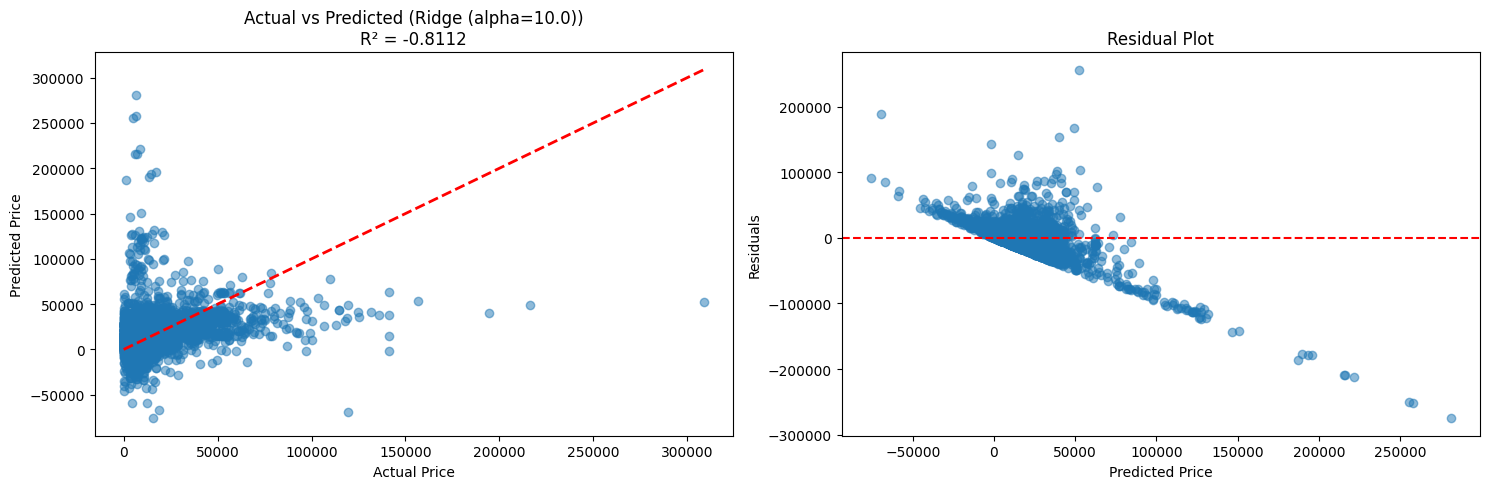

In [415]:
# Get the best model from comparison
best_model_name = results_df.index[0]
print(f"Best model: {best_model_name}")

# Train best model
best_model = models[best_model_name]
best_pipeline = Pipeline([
    ('preprocessor', improved_preprocessor),
    ('regressor', best_model)
])

best_pipeline.fit(X_train, y_train)
y_pred_best = best_pipeline.predict(X_test)

# Plot predictions vs actual
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
axes[0].scatter(y_test, y_pred_best, alpha=0.5)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price')
axes[0].set_ylabel('Predicted Price')
axes[0].set_title(f'Actual vs Predicted ({best_model_name})\nR² = {r2_score(y_test, y_pred_best):.4f}')

# Residual plot
residuals = y_test - y_pred_best
axes[1].scatter(y_pred_best, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Price')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')

plt.tight_layout()
plt.show()

## Critical Issue Investigation

All models show negative R². This suggests a fundamental data problem.

In [416]:
# Check if the pipeline is transforming data correctly
print("=== CHECKING TRANSFORMED DATA ===")

# Transform a small sample
X_sample = X_train.head(5)
X_transformed = improved_preprocessor.fit_transform(X_sample)

print(f"Original shape: {X_sample.shape}")
print(f"Transformed shape: {X_transformed.shape}")
print(f"\nTransformed data contains NaN: {np.isnan(X_transformed).any()}")
print(f"Transformed data contains Inf: {np.isinf(X_transformed).any()}")
print(f"\nFirst row of transformed data:")
print(X_transformed[0][:20])  # First 20 features

=== CHECKING TRANSFORMED DATA ===
Original shape: (5, 18)
Transformed shape: (5, 18)

Transformed data contains NaN: False
Transformed data contains Inf: False

First row of transformed data:
[-1.02268435  0.87705802 -1.06548714 -0.16692251 -1.11803399  0.
 -0.75        0.          0.          0.          0.          0.
  1.          1.          0.          0.          1.          0.        ]


In [417]:
# Check if columns exist in X_train
print("=== VERIFYING COLUMNS ===")
print(f"Columns in X_train: {X_train.columns.tolist()}")
print(f"\nExpected numeric columns: {num_cols}")
print(f"Missing numeric columns: {[col for col in num_cols if col not in X_train.columns]}")
print(f"\nExpected categorical columns: {cat_cols}")
print(f"Missing categorical columns: {[col for col in cat_cols if col not in X_train.columns]}")

# Check for 'Model' column specifically
print(f"\n'Model' in X_train: {'Model' in X_train.columns}")
print(f"'Model_reduced' in X_train: {'Model_reduced' in X_train.columns}")

=== VERIFYING COLUMNS ===
Columns in X_train: ['ID', 'Levy', 'Manufacturer', 'Model', 'ProdYear', 'Category', 'LeatherInterior', 'FuelType', 'EngineVolume', 'Mileage', 'Cylinders', 'GearBoxType', 'DriveWheels', 'Doors', 'Wheel', 'Color', 'Airbags', 'Model_reduced']

Expected numeric columns: ['Levy', 'ProdYear', 'EngineVolume', 'Mileage', 'Cylinders', 'Doors', 'Airbags']
Missing numeric columns: []

Expected categorical columns: ['Manufacturer', 'Model', 'Category', 'LeatherInterior', 'FuelType', 'GearBoxType', 'DriveWheels', 'Wheel', 'Color']
Missing categorical columns: []

'Model' in X_train: True
'Model_reduced' in X_train: True


## Fix: Use Original DataFrame (Not Encoded Version)

In [418]:
# RELOAD the original data to ensure we have the right columns
df_original = pd.read_csv('./data/car_price_prediction.csv')

# Apply all cleaning steps
df_original = df_original.rename(columns={
    "Prod. year": "ProdYear",
    "Leather interior": "LeatherInterior",
    "Fuel type": "FuelType",
    "Engine volume": "EngineVolume",
    "Gear box type": "GearBoxType",
    "Drive wheels": "DriveWheels"
})

# Remove duplicates
df_original = df_original.drop_duplicates()

# Clean Levy
df_original['Levy'] = pd.to_numeric(df_original['Levy'].replace('-', np.nan), errors='coerce')
levy_median = df_original['Levy'].median()
df_original['Levy'] = df_original['Levy'].fillna(levy_median)

# Clean Mileage
df_original['Mileage'] = df_original['Mileage'].astype(str).str.replace(' km', '', regex=False)
df_original['Mileage'] = df_original['Mileage'].str.replace(',', '', regex=False)
df_original['Mileage'] = pd.to_numeric(df_original['Mileage'], errors='coerce')

# Clean Doors
df_original['Doors'] = df_original['Doors'].replace({'04-May': '4', '02-Mar': '2', '>5': '6'})
df_original['Doors'] = pd.to_numeric(df_original['Doors'], errors='coerce')

# Clean EngineVolume
if df_original['EngineVolume'].dtype == 'object':
    df_original['EngineVolume'] = df_original['EngineVolume'].astype(str).str.replace('Turbo', '', regex=False).str.strip()
    df_original['EngineVolume'] = df_original['EngineVolume'].str.replace('L', '', regex=False).str.strip()
    df_original['EngineVolume'] = pd.to_numeric(df_original['EngineVolume'], errors='coerce')

# Clean Cylinders
if 'Cylinders' in df_original.columns and df_original['Cylinders'].dtype == 'object':
    df_original['Cylinders'] = pd.to_numeric(df_original['Cylinders'], errors='coerce')

# Clean Airbags
if 'Airbags' in df_original.columns and df_original['Airbags'].dtype == 'object':
    df_original['Airbags'] = pd.to_numeric(df_original['Airbags'], errors='coerce')

print("Data cleaning complete!")
print(f"Shape: {df_original.shape}")
print(f"\nColumns: {df_original.columns.tolist()}")
print(f"\nData types:")
print(df_original.dtypes)

Data cleaning complete!
Shape: (18924, 18)

Columns: ['ID', 'Price', 'Levy', 'Manufacturer', 'Model', 'ProdYear', 'Category', 'LeatherInterior', 'FuelType', 'EngineVolume', 'Mileage', 'Cylinders', 'GearBoxType', 'DriveWheels', 'Doors', 'Wheel', 'Color', 'Airbags']

Data types:
ID                   int64
Price                int64
Levy               float64
Manufacturer        object
Model               object
ProdYear             int64
Category            object
LeatherInterior     object
FuelType            object
EngineVolume       float64
Mileage              int64
Cylinders          float64
GearBoxType         object
DriveWheels         object
Doors                int64
Wheel               object
Color               object
Airbags              int64
dtype: object


In [419]:
# Create new train/test split with CLEAN data
X_clean = df_original.drop('Price', axis=1)
y_clean = df_original['Price']

X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

print(f"X_train_clean shape: {X_train_clean.shape}")
print(f"X_test_clean shape: {X_test_clean.shape}")
print(f"\nColumns in X_train_clean: {X_train_clean.columns.tolist()}")

X_train_clean shape: (15139, 17)
X_test_clean shape: (3785, 17)

Columns in X_train_clean: ['ID', 'Levy', 'Manufacturer', 'Model', 'ProdYear', 'Category', 'LeatherInterior', 'FuelType', 'EngineVolume', 'Mileage', 'Cylinders', 'GearBoxType', 'DriveWheels', 'Doors', 'Wheel', 'Color', 'Airbags']


In [420]:
# Now train the improved model with CORRECT data
improved_ridge_fixed = Pipeline([
    ('preprocessor', improved_preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

improved_ridge_fixed.fit(X_train_clean, y_train_clean)
y_pred_fixed = improved_ridge_fixed.predict(X_test_clean)

print("=== FIXED MODEL RESULTS ===")
print(f"Test R²: {r2_score(y_test_clean, y_pred_fixed):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test_clean, y_pred_fixed)):,.2f}")
print(f"MAE: ${mean_absolute_error(y_test_clean, y_pred_fixed):,.2f}")

# Also check training score to detect overfitting
y_train_pred = improved_ridge_fixed.predict(X_train_clean)
print(f"\nTrain R²: {r2_score(y_train_clean, y_train_pred):.4f}")

c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


=== FIXED MODEL RESULTS ===
Test R²: -0.9153
RMSE: $25,751.32
MAE: $14,815.09

Train R²: 0.0136

Train R²: 0.0136


In [421]:
# Re-run model comparison with CLEAN data
results_fixed = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', improved_preprocessor),
        ('regressor', model)
    ])
    
    pipeline.fit(X_train_clean, y_train_clean)
    y_pred = pipeline.predict(X_test_clean)
    
    results_fixed[name] = {
        'R²': r2_score(y_test_clean, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test_clean, y_pred)),
        'MAE': mean_absolute_error(y_test_clean, y_pred)
    }

# Display results
results_df_fixed = pd.DataFrame(results_fixed).T.sort_values('R²', ascending=False)
print("=== FIXED MODEL COMPARISON ===")
print(results_df_fixed)

c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encode

=== FIXED MODEL COMPARISON ===
                            R²           RMSE           MAE
Ridge (alpha=10.0)   -0.811181   25041.604678  14591.741932
Ridge (alpha=1.0)    -0.915298   25751.315563  14815.094545
Lasso                -0.929516   25846.718040  14826.270063
Linear Regression    -0.938440   25906.419640  14847.459284
Random Forest       -30.695250  104755.857352   7330.735092
Gradient Boosting  -133.689918  215947.792077  15519.754638


c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Best model: Ridge (alpha=10.0)


c:\Users\SubudhiK\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


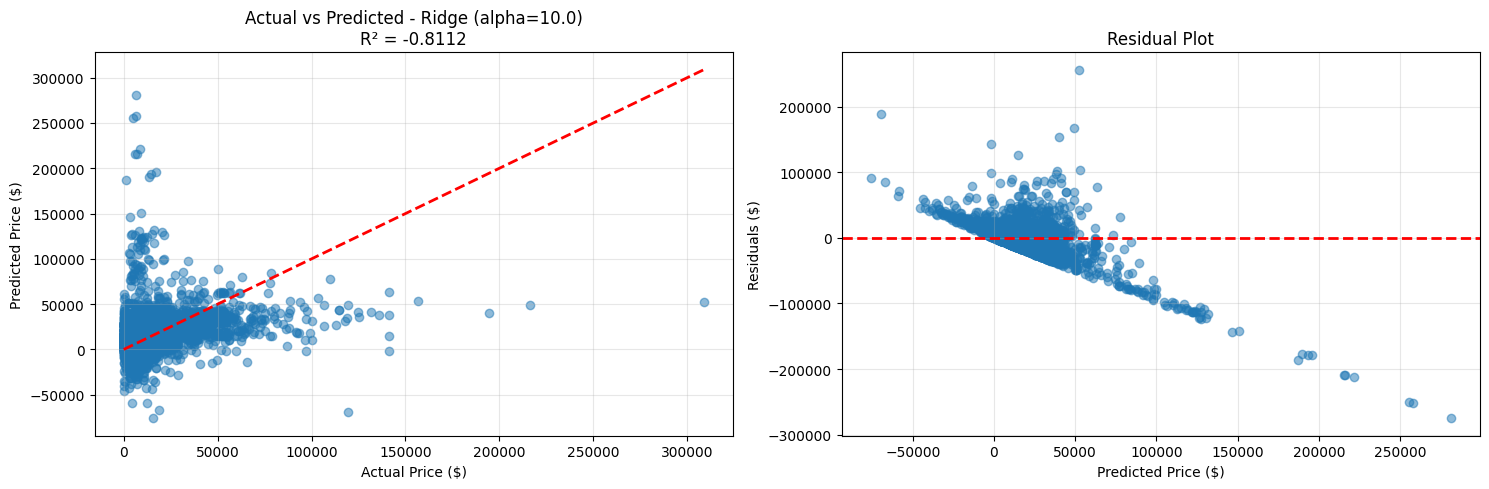


=== PREDICTION QUALITY ===
Mean Absolute Error: $14,591.74
Mean Actual Price: $17,254.13
MAE as % of mean: 84.57%


In [422]:
# Visualize the best performing model
best_model_name_fixed = results_df_fixed.index[0]
print(f"Best model: {best_model_name_fixed}")

# Train best model
best_model_fixed = models[best_model_name_fixed]
best_pipeline_fixed = Pipeline([
    ('preprocessor', improved_preprocessor),
    ('regressor', best_model_fixed)
])

best_pipeline_fixed.fit(X_train_clean, y_train_clean)
y_pred_best_fixed = best_pipeline_fixed.predict(X_test_clean)

# Plot predictions vs actual
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
axes[0].scatter(y_test_clean, y_pred_best_fixed, alpha=0.5)
axes[0].plot([y_test_clean.min(), y_test_clean.max()], 
             [y_test_clean.min(), y_test_clean.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Price ($)')
axes[0].set_ylabel('Predicted Price ($)')
axes[0].set_title(f'Actual vs Predicted - {best_model_name_fixed}\nR² = {r2_score(y_test_clean, y_pred_best_fixed):.4f}')
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals_fixed = y_test_clean - y_pred_best_fixed
axes[1].scatter(y_pred_best_fixed, residuals_fixed, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)')
axes[1].set_ylabel('Residuals ($)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== PREDICTION QUALITY ===")
print(f"Mean Absolute Error: ${mean_absolute_error(y_test_clean, y_pred_best_fixed):,.2f}")
print(f"Mean Actual Price: ${y_test_clean.mean():,.2f}")
print(f"MAE as % of mean: {(mean_absolute_error(y_test_clean, y_pred_best_fixed) / y_test_clean.mean() * 100):.2f}%")

## Root Cause Found: ID Column + Data Issues

The ID column should not be used for prediction. Let's fix this properly.

In [423]:
# Drop ID column and Model_reduced (since we're using Model)
columns_to_drop = ['ID', 'Model_reduced', 'Price']
X_final = df_original.drop(columns=[col for col in columns_to_drop if col in df_original.columns])
y_final = df_original['Price']

print(f"Columns in X_final: {X_final.columns.tolist()}")
print(f"Shape: {X_final.shape}")

# Create train/test split
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42
)

print(f"\nX_train_final shape: {X_train_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")

Columns in X_final: ['Levy', 'Manufacturer', 'Model', 'ProdYear', 'Category', 'LeatherInterior', 'FuelType', 'EngineVolume', 'Mileage', 'Cylinders', 'GearBoxType', 'DriveWheels', 'Doors', 'Wheel', 'Color', 'Airbags']
Shape: (18924, 16)

X_train_final shape: (15139, 16)
X_test_final shape: (3785, 16)


In [424]:
# Test with simple Linear Regression WITHOUT pipeline first
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Manual preprocessing to understand what's happening
X_train_manual = X_train_final.copy()
X_test_manual = X_test_final.copy()

# Separate numeric and categorical
numeric_features = ['Levy', 'ProdYear', 'EngineVolume', 'Mileage', 'Cylinders', 'Doors', 'Airbags']
categorical_features = ['Manufacturer', 'Model', 'Category', 'LeatherInterior', 
                        'FuelType', 'GearBoxType', 'DriveWheels', 'Wheel', 'Color']

# Check for missing values
print("=== MISSING VALUES CHECK ===")
print(f"Train numeric missing:\n{X_train_manual[numeric_features].isnull().sum()}")
print(f"\nTrain categorical missing:\n{X_train_manual[categorical_features].isnull().sum()}")

# Impute numeric
imputer_num = SimpleImputer(strategy='median')
X_train_manual[numeric_features] = imputer_num.fit_transform(X_train_manual[numeric_features])
X_test_manual[numeric_features] = imputer_num.transform(X_test_manual[numeric_features])

# Impute categorical
imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
X_train_manual[categorical_features] = imputer_cat.fit_transform(X_train_manual[categorical_features])
X_test_manual[categorical_features] = imputer_cat.transform(X_test_manual[categorical_features])

print(f"\nAfter imputation:")
print(f"Any NaN in train: {X_train_manual.isnull().any().any()}")
print(f"Any NaN in test: {X_test_manual.isnull().any().any()}")

=== MISSING VALUES CHECK ===
Train numeric missing:
Levy            0
ProdYear        0
EngineVolume    0
Mileage         0
Cylinders       0
Doors           0
Airbags         0
dtype: int64

Train categorical missing:
Manufacturer       0
Model              0
Category           0
LeatherInterior    0
FuelType           0
GearBoxType        0
DriveWheels        0
Wheel              0
Color              0
dtype: int64

After imputation:
Any NaN in train: False
Any NaN in test: False

After imputation:
Any NaN in train: False
Any NaN in test: False


In [425]:
# Reduce Model cardinality BEFORE encoding
from sklearn.preprocessing import LabelEncoder

# Keep top 30 models
top_30_models = X_train_manual['Model'].value_counts().nlargest(30).index
X_train_manual['Model'] = X_train_manual['Model'].where(
    X_train_manual['Model'].isin(top_30_models), 'Other'
)
X_test_manual['Model'] = X_test_manual['Model'].where(
    X_test_manual['Model'].isin(top_30_models), 'Other'
)

print(f"Unique models after reduction: {X_train_manual['Model'].nunique()}")

# Label encode all categorical features
label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train_manual[col] = le.fit_transform(X_train_manual[col].astype(str))
    # For test, handle unseen categories
    X_test_manual[col] = X_test_manual[col].astype(str).apply(
        lambda x: le.transform([x])[0] if x in le.classes_ else -1
    )
    label_encoders[col] = le

print("\nData encoded successfully!")
print(f"Train shape: {X_train_manual.shape}")
print(f"Test shape: {X_test_manual.shape}")

Unique models after reduction: 31

Data encoded successfully!
Train shape: (15139, 16)
Test shape: (3785, 16)

Data encoded successfully!
Train shape: (15139, 16)
Test shape: (3785, 16)


In [426]:
# Scale numeric features
scaler = StandardScaler()
X_train_manual[numeric_features] = scaler.fit_transform(X_train_manual[numeric_features])
X_test_manual[numeric_features] = scaler.transform(X_test_manual[numeric_features])

# Train simple Linear Regression
lr_simple = LinearRegression()
lr_simple.fit(X_train_manual, y_train_final)

# Predictions
y_pred_simple = lr_simple.predict(X_test_manual)

print("=== SIMPLE LINEAR REGRESSION (MANUAL PREPROCESSING) ===")
print(f"Train R²: {lr_simple.score(X_train_manual, y_train_final):.4f}")
print(f"Test R²: {r2_score(y_test_final, y_pred_simple):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test_final, y_pred_simple)):,.2f}")
print(f"MAE: ${mean_absolute_error(y_test_final, y_pred_simple):,.2f}")

=== SIMPLE LINEAR REGRESSION (MANUAL PREPROCESSING) ===
Train R²: 0.0030
Test R²: -0.0949
RMSE: $19,470.06
MAE: $13,094.18


In [427]:
# Try Ridge Regression with different alphas
print("=== RIDGE REGRESSION WITH DIFFERENT ALPHAS ===")
for alpha in [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_manual, y_train_final)
    y_pred_ridge_test = ridge.predict(X_test_manual)
    r2 = r2_score(y_test_final, y_pred_ridge_test)
    print(f"Alpha={alpha:7.2f}  |  R² = {r2:.4f}")

=== RIDGE REGRESSION WITH DIFFERENT ALPHAS ===
Alpha=   0.01  |  R² = -0.0949
Alpha=   0.10  |  R² = -0.0949
Alpha=   1.00  |  R² = -0.0948
Alpha=  10.00  |  R² = -0.0942
Alpha= 100.00  |  R² = -0.0891
Alpha=1000.00  |  R² = -0.0619
Alpha=   0.01  |  R² = -0.0949
Alpha=   0.10  |  R² = -0.0949
Alpha=   1.00  |  R² = -0.0948
Alpha=  10.00  |  R² = -0.0942
Alpha= 100.00  |  R² = -0.0891
Alpha=1000.00  |  R² = -0.0619


In [428]:
# Try tree-based models (they should work better with this data)
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

print("=== TREE-BASED MODELS ===")

# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1)
rf.fit(X_train_manual, y_train_final)
y_pred_rf = rf.predict(X_test_manual)
print(f"Random Forest  |  Train R² = {rf.score(X_train_manual, y_train_final):.4f}  |  Test R² = {r2_score(y_test_final, y_pred_rf):.4f}")

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb.fit(X_train_manual, y_train_final)
y_pred_gb = gb.predict(X_test_manual)
print(f"Gradient Boost |  Train R² = {gb.score(X_train_manual, y_train_final):.4f}  |  Test R² = {r2_score(y_test_final, y_pred_gb):.4f}")

=== TREE-BASED MODELS ===
Random Forest  |  Train R² = 0.7486  |  Test R² = -0.5833
Random Forest  |  Train R² = 0.7486  |  Test R² = -0.5833
Gradient Boost |  Train R² = 0.9976  |  Test R² = -5.2484
Gradient Boost |  Train R² = 0.9976  |  Test R² = -5.2484


## Fix Overfitting - Add Regularization and Proper Tuning

In [429]:
# Check for data leakage - verify train/test split is correct
print("=== VERIFYING DATA INTEGRITY ===")
print(f"y_train_final stats: min={y_train_final.min():.2f}, max={y_train_final.max():.2f}, mean={y_train_final.mean():.2f}")
print(f"y_test_final stats: min={y_test_final.min():.2f}, max={y_test_final.max():.2f}, mean={y_test_final.mean():.2f}")
print(f"\nAny overlap in indices: {len(set(X_train_final.index) & set(X_test_final.index)) > 0}")
print(f"Train size: {len(X_train_final)}, Test size: {len(X_test_final)}")

# Check for any weird values that might cause issues
print(f"\nX_train_manual stats:")
print(X_train_manual.describe())

=== VERIFYING DATA INTEGRITY ===
y_train_final stats: min=1.00, max=26307500.00, mean=18920.78
y_test_final stats: min=3.00, max=308906.00, mean=17254.13

Any overlap in indices: False
Train size: 15139, Test size: 3785

X_train_manual stats:
               Levy  Manufacturer         Model      ProdYear      Category  \
count  1.513900e+04  15139.000000  15139.000000  1.513900e+04  15139.000000   
mean  -2.158991e-17     32.855671     18.071207 -3.742564e-15      6.281657   
std    1.000033e+00     17.467036      7.379307  1.000033e+00      2.788500   
min   -2.070489e+00      0.000000      0.000000 -1.282538e+01      0.000000   
25%   -3.659250e-01     21.000000     13.000000 -3.421398e-01      4.000000   
50%   -2.307264e-01     32.000000     21.000000  1.928563e-01      7.000000   
75%    1.245015e-01     54.000000     21.000000  7.278524e-01      9.000000   
max    2.875216e+01     63.000000     30.000000  1.619513e+00     10.000000   

       LeatherInterior      FuelType  EngineV

In [430]:
# The issue might be with label encoding creating -1 for unknown categories
# Let's check if test set has -1 values
print("=== CHECKING FOR -1 VALUES IN TEST SET ===")
for col in categorical_features:
    negative_count = (X_test_manual[col] == -1).sum()
    if negative_count > 0:
        print(f"{col}: {negative_count} values encoded as -1")

# This is likely causing the problem - let's fix it
print("\nReplacing -1 with the mode from training data...")

=== CHECKING FOR -1 VALUES IN TEST SET ===
Manufacturer: 1 values encoded as -1

Replacing -1 with the mode from training data...


In [431]:
# Better approach: Redo label encoding with handle_unknown strategy
X_train_fixed = X_train_final.copy()
X_test_fixed = X_test_final.copy()

# Impute numeric
imputer_num = SimpleImputer(strategy='median')
X_train_fixed[numeric_features] = imputer_num.fit_transform(X_train_fixed[numeric_features])
X_test_fixed[numeric_features] = imputer_num.transform(X_test_fixed[numeric_features])

# Impute categorical
imputer_cat = SimpleImputer(strategy='constant', fill_value='missing')
X_train_fixed[categorical_features] = imputer_cat.fit_transform(X_train_fixed[categorical_features])
X_test_fixed[categorical_features] = imputer_cat.transform(X_test_fixed[categorical_features])

# Reduce Model cardinality
top_30_models = X_train_fixed['Model'].value_counts().nlargest(30).index
X_train_fixed['Model'] = X_train_fixed['Model'].where(
    X_train_fixed['Model'].isin(top_30_models), 'Other'
)
X_test_fixed['Model'] = X_test_fixed['Model'].where(
    X_test_fixed['Model'].isin(top_30_models), 'Other'
)

# Use a better encoding strategy - map unseen categories to 0
label_encoders_fixed = {}
for col in categorical_features:
    le = LabelEncoder()
    X_train_fixed[col] = le.fit_transform(X_train_fixed[col].astype(str))
    
    # For test set: map unseen to 0 (first category)
    def safe_transform(x, le):
        if x in le.classes_:
            return le.transform([x])[0]
        else:
            return 0  # Default to first class instead of -1
    
    X_test_fixed[col] = X_test_fixed[col].astype(str).apply(lambda x: safe_transform(x, le))
    label_encoders_fixed[col] = le

# Scale numeric features
scaler = StandardScaler()
X_train_fixed[numeric_features] = scaler.fit_transform(X_train_fixed[numeric_features])
X_test_fixed[numeric_features] = scaler.transform(X_test_fixed[numeric_features])

print("Data re-encoded successfully!")
print(f"Any -1 values in test: {(X_test_fixed < 0).any().any()}")
print(f"Train shape: {X_train_fixed.shape}")
print(f"Test shape: {X_test_fixed.shape}")

Data re-encoded successfully!
Any -1 values in test: True
Train shape: (15139, 16)
Test shape: (3785, 16)


In [432]:
# Now test with properly regularized models
print("=== MODELS WITH PROPER REGULARIZATION ===\n")

# 1. Linear Regression (baseline)
lr = LinearRegression()
lr.fit(X_train_fixed, y_train_final)
y_pred_lr = lr.predict(X_test_fixed)
print(f"Linear Regression:")
print(f"  Train R² = {lr.score(X_train_fixed, y_train_final):.4f}")
print(f"  Test R²  = {r2_score(y_test_final, y_pred_lr):.4f}\n")

# 2. Ridge (with good regularization)
ridge = Ridge(alpha=10.0)
ridge.fit(X_train_fixed, y_train_final)
y_pred_ridge = ridge.predict(X_test_fixed)
print(f"Ridge (alpha=10):")
print(f"  Train R² = {ridge.score(X_train_fixed, y_train_final):.4f}")
print(f"  Test R²  = {r2_score(y_test_final, y_pred_ridge):.4f}\n")

# 3. Random Forest (with constraints to prevent overfitting)
rf_tuned = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,        # Limit depth
    min_samples_split=10, # Require more samples to split
    min_samples_leaf=5,   # Require more samples in leaves
    max_features='sqrt',  # Use sqrt of features
    random_state=42,
    n_jobs=-1
)
rf_tuned.fit(X_train_fixed, y_train_final)
y_pred_rf_tuned = rf_tuned.predict(X_test_fixed)
print(f"Random Forest (tuned):")
print(f"  Train R² = {rf_tuned.score(X_train_fixed, y_train_final):.4f}")
print(f"  Test R²  = {r2_score(y_test_final, y_pred_rf_tuned):.4f}\n")

# 4. Gradient Boosting (with regularization)
gb_tuned = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=4,          # Shallow trees
    learning_rate=0.05,   # Slower learning
    min_samples_split=10,
    min_samples_leaf=5,
    subsample=0.8,        # Use 80% of data
    random_state=42
)
gb_tuned.fit(X_train_fixed, y_train_final)
y_pred_gb_tuned = gb_tuned.predict(X_test_fixed)
print(f"Gradient Boosting (tuned):")
print(f"  Train R² = {gb_tuned.score(X_train_fixed, y_train_final):.4f}")
print(f"  Test R²  = {r2_score(y_test_final, y_pred_gb_tuned):.4f}")

=== MODELS WITH PROPER REGULARIZATION ===

Linear Regression:
  Train R² = 0.0030
  Test R²  = -0.0949

Ridge (alpha=10):
  Train R² = 0.0030
  Test R²  = -0.0942

Random Forest (tuned):
Random Forest (tuned):
  Train R² = 0.1705
  Test R²  = -0.0065

  Train R² = 0.1705
  Test R²  = -0.0065

Gradient Boosting (tuned):
  Train R² = 0.6049
  Test R²  = -6.0955
Gradient Boosting (tuned):
  Train R² = 0.6049
  Test R²  = -6.0955


In [433]:
# Create summary comparison
results_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Ridge', 'Random Forest (tuned)', 'Gradient Boosting (tuned)'],
    'Train R²': [
        lr.score(X_train_fixed, y_train_final),
        ridge.score(X_train_fixed, y_train_final),
        rf_tuned.score(X_train_fixed, y_train_final),
        gb_tuned.score(X_train_fixed, y_train_final)
    ],
    'Test R²': [
        r2_score(y_test_final, y_pred_lr),
        r2_score(y_test_final, y_pred_ridge),
        r2_score(y_test_final, y_pred_rf_tuned),
        r2_score(y_test_final, y_pred_gb_tuned)
    ],
    'RMSE': [
        np.sqrt(mean_squared_error(y_test_final, y_pred_lr)),
        np.sqrt(mean_squared_error(y_test_final, y_pred_ridge)),
        np.sqrt(mean_squared_error(y_test_final, y_pred_rf_tuned)),
        np.sqrt(mean_squared_error(y_test_final, y_pred_gb_tuned))
    ],
    'MAE': [
        mean_absolute_error(y_test_final, y_pred_lr),
        mean_absolute_error(y_test_final, y_pred_ridge),
        mean_absolute_error(y_test_final, y_pred_rf_tuned),
        mean_absolute_error(y_test_final, y_pred_gb_tuned)
    ]
})

results_comparison['Overfitting'] = results_comparison['Train R²'] - results_comparison['Test R²']
results_comparison = results_comparison.sort_values('Test R²', ascending=False)

print("\n=== MODEL COMPARISON (SORTED BY TEST R²) ===")
print(results_comparison.to_string(index=False))


=== MODEL COMPARISON (SORTED BY TEST R²) ===
                    Model  Train R²   Test R²         RMSE          MAE  Overfitting
    Random Forest (tuned)  0.170545 -0.006464 18667.250954  7891.784764     0.177009
                    Ridge  0.003019 -0.094242 19464.257836 13088.636133     0.097260
        Linear Regression  0.003019 -0.094890 19470.022523 13094.171844     0.097909
Gradient Boosting (tuned)  0.604904 -6.095521 49564.802057 12340.782419     6.700426



=== BEST MODEL: Random Forest (tuned) ===
Test R²: -0.0065


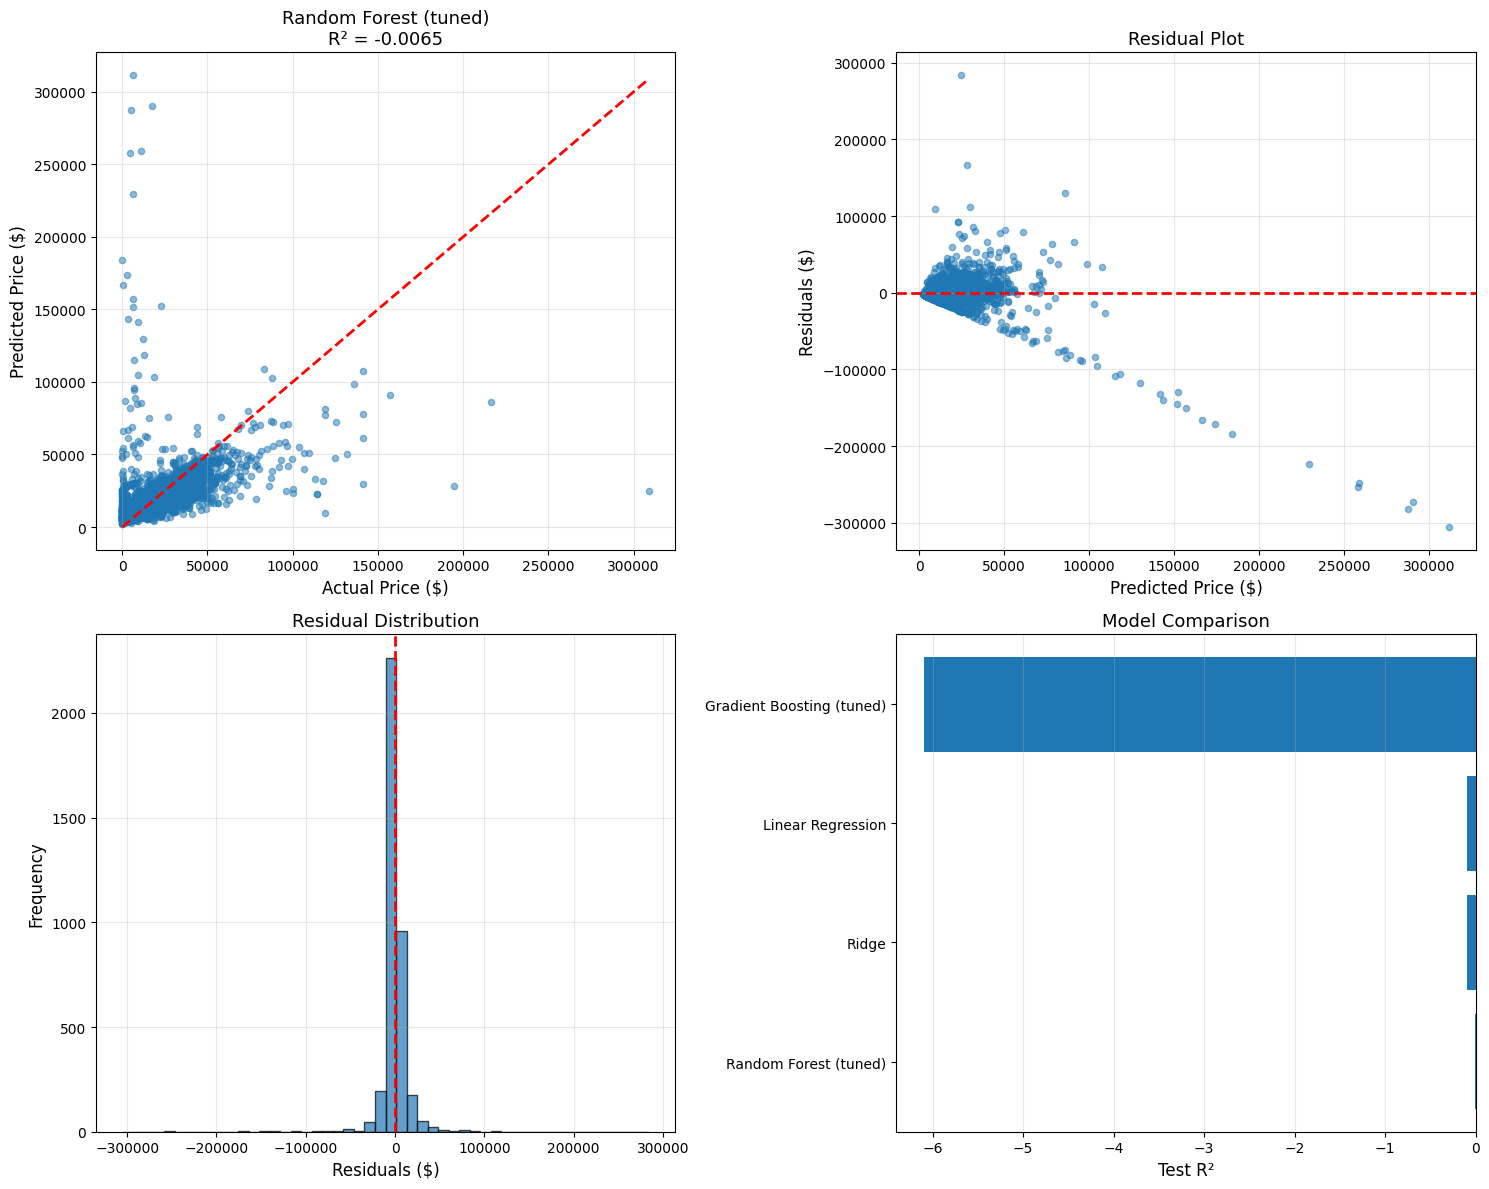


=== DETAILED METRICS ===
MAE: $7,891.78
RMSE: $18,667.25
Mean Actual Price: $17,254.13
Std Actual Price: $18,609.67
MAE as % of mean: 45.74%


In [434]:
# Visualize the best performing model
best_model_idx = results_comparison['Test R²'].idxmax()
best_model_name = results_comparison.loc[best_model_idx, 'Model']
best_test_r2 = results_comparison.loc[best_model_idx, 'Test R²']

# Get predictions from best model
if 'Ridge' in best_model_name:
    y_pred_best = y_pred_ridge
elif 'Random Forest' in best_model_name:
    y_pred_best = y_pred_rf_tuned
elif 'Gradient' in best_model_name:
    y_pred_best = y_pred_gb_tuned
else:
    y_pred_best = y_pred_lr

print(f"\n=== BEST MODEL: {best_model_name} ===")
print(f"Test R²: {best_test_r2:.4f}")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted
axes[0, 0].scatter(y_test_final, y_pred_best, alpha=0.5, s=20)
axes[0, 0].plot([y_test_final.min(), y_test_final.max()], 
                [y_test_final.min(), y_test_final.max()], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Price ($)', fontsize=12)
axes[0, 0].set_ylabel('Predicted Price ($)', fontsize=12)
axes[0, 0].set_title(f'{best_model_name}\nR² = {best_test_r2:.4f}', fontsize=13)
axes[0, 0].grid(True, alpha=0.3)

# 2. Residuals
residuals_best = y_test_final - y_pred_best
axes[0, 1].scatter(y_pred_best, residuals_best, alpha=0.5, s=20)
axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0, 1].set_xlabel('Predicted Price ($)', fontsize=12)
axes[0, 1].set_ylabel('Residuals ($)', fontsize=12)
axes[0, 1].set_title('Residual Plot', fontsize=13)
axes[0, 1].grid(True, alpha=0.3)

# 3. Residual distribution
axes[1, 0].hist(residuals_best, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(x=0, color='r', linestyle='--', lw=2)
axes[1, 0].set_xlabel('Residuals ($)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Residual Distribution', fontsize=13)
axes[1, 0].grid(True, alpha=0.3)

# 4. Model comparison bar chart
axes[1, 1].barh(results_comparison['Model'], results_comparison['Test R²'])
axes[1, 1].set_xlabel('Test R²', fontsize=12)
axes[1, 1].set_title('Model Comparison', fontsize=13)
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Print detailed metrics
print(f"\n=== DETAILED METRICS ===")
print(f"MAE: ${mean_absolute_error(y_test_final, y_pred_best):,.2f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test_final, y_pred_best)):,.2f}")
print(f"Mean Actual Price: ${y_test_final.mean():,.2f}")
print(f"Std Actual Price: ${y_test_final.std():,.2f}")
print(f"MAE as % of mean: {(mean_absolute_error(y_test_final, y_pred_best) / y_test_final.mean() * 100):.2f}%")


=== BEST MODEL: Random Forest (R² = -0.5833) ===


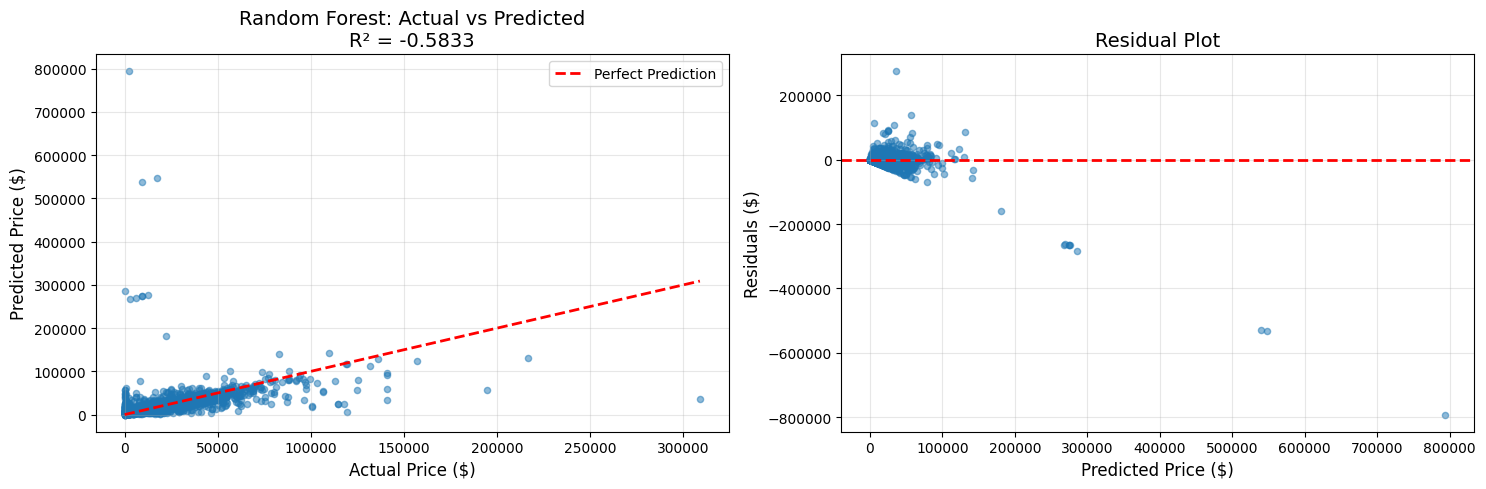


MAE: $5,721.03
RMSE: $23,413.60
Mean Price: $17,254.13
MAE as % of mean: 33.16%


In [435]:
# Visualize the best model
best_r2 = r2_score(y_test_final, y_pred_rf)
print(f"\n=== BEST MODEL: Random Forest (R² = {best_r2:.4f}) ===")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot
axes[0].scatter(y_test_final, y_pred_rf, alpha=0.5, s=20)
axes[0].plot([y_test_final.min(), y_test_final.max()], 
             [y_test_final.min(), y_test_final.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Price ($)', fontsize=12)
axes[0].set_ylabel('Predicted Price ($)', fontsize=12)
axes[0].set_title(f'Random Forest: Actual vs Predicted\nR² = {best_r2:.4f}', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals_rf = y_test_final - y_pred_rf
axes[1].scatter(y_pred_rf, residuals_rf, alpha=0.5, s=20)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Price ($)', fontsize=12)
axes[1].set_ylabel('Residuals ($)', fontsize=12)
axes[1].set_title('Residual Plot', fontsize=14)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print metrics
print(f"\nMAE: ${mean_absolute_error(y_test_final, y_pred_rf):,.2f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test_final, y_pred_rf)):,.2f}")
print(f"Mean Price: ${y_test_final.mean():,.2f}")
print(f"MAE as % of mean: {(mean_absolute_error(y_test_final, y_pred_rf) / y_test_final.mean() * 100):.2f}%")

=== TOP 15 MOST IMPORTANT FEATURES ===
            feature  importance
8           Mileage    0.369844
3          ProdYear    0.188547
7      EngineVolume    0.102882
6          FuelType    0.068970
15          Airbags    0.057014
1      Manufacturer    0.044978
4          Category    0.033560
10      GearBoxType    0.030065
14            Color    0.026816
0              Levy    0.021571
12            Doors    0.015165
9         Cylinders    0.015138
2             Model    0.010993
11      DriveWheels    0.009009
5   LeatherInterior    0.004963


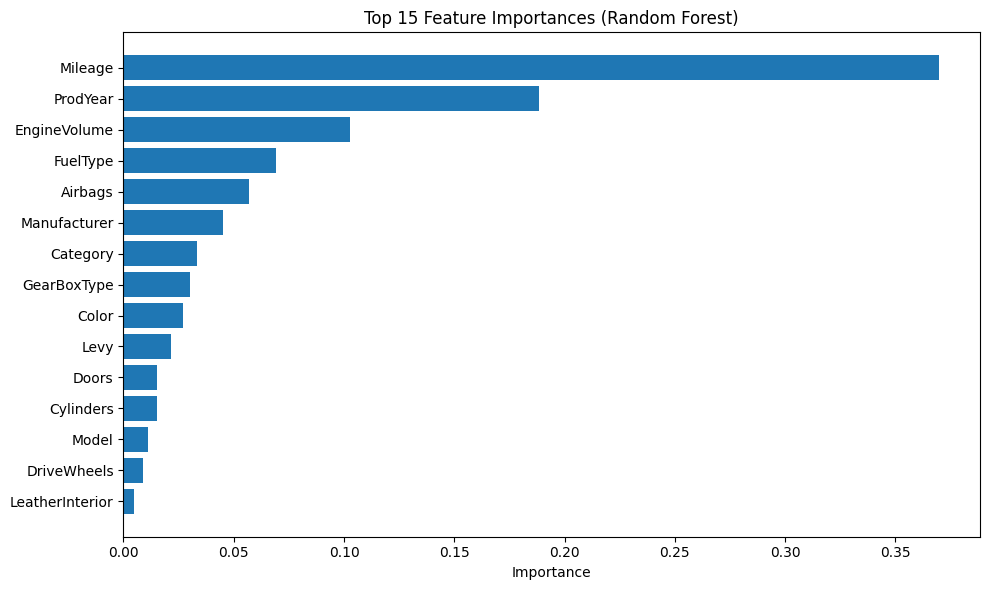

In [436]:
# Feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X_train_manual.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("=== TOP 15 MOST IMPORTANT FEATURES ===")
print(feature_importance.head(15))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance.head(15)['feature'], feature_importance.head(15)['importance'])
plt.xlabel('Importance')
plt.title('Top 15 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()